##Printing distribution of labels after every split

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
#from skmultilearn.model_selection import IterativeStratifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from torch.amp import GradScaler, autocast
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.8 MB/s eta 0:00:00


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

torch.cuda.empty_cache()

Using device: cuda


In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/HCI Master courses/THESIS/frames_parsed.csv')
dataframe['context'] = dataframe['context'].fillna('')  # Replace NaN with empty string
dataframe['context'] = dataframe['context'].astype(str)  # Ensure all entries are strings
dataframe['DA_list'] = dataframe['DA'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(dataframe['DA_list'])

In [ ]:
class FramesDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = str(self.dataframe.iloc[idx]['context'])  # Ensure text is a string
        labels = self.dataframe.iloc[idx]['DA_list']  # Assuming labels are already lists
        labels = mlb.transform([labels])[0]  # Convert to binary vector

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float32)
        }

In [ ]:
def train_and_evaluate(model, train_dataloader, val_dataloader, device, optimizer, fold, epoch):
    loss_fn = BCEWithLogitsLoss()
    scaler = GradScaler()

    # Training
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with autocast(device_type='cuda'):
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch['labels'])
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        total_loss += loss.item()

    # Validation
    model.eval()
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.sigmoid(logits).round()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy


In [ ]:
def k_fold_cross_validation(dataframe, k=5, epochs=3):
    stratifier = IterativeStratification(n_splits=k, order=1)
    label_counts = []

    for fold_number, (train_index, test_index) in enumerate(stratifier.split(dataframe, labels)):
        train_df = dataframe.iloc[train_index]
        test_df = dataframe.iloc[test_index]
        train_dataset = FramesDataset(train_df, tokenizer)
        test_dataset = FramesDataset(test_df, tokenizer)
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=8)

        # Model setup
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = RobertaForSequenceClassification(RobertaConfig.from_pretrained('roberta-base', num_labels=len(mlb.classes_)))
        model.to(device)
        optimizer = AdamW(model.parameters(), lr=5e-5)

        # Train and evaluate model across specified epochs
        for epoch in range(1, epochs + 1):
            accuracy = train_and_evaluate(model, train_dataloader, test_dataloader, device, optimizer, fold=fold_number+1, epoch=epoch)
            print(f"Fold {fold_number+1}, Epoch {epoch}, Accuracy: {accuracy:.4f}")

        # Count labels in each split
        train_label_counts = Counter([label for sublist in train_df['DA_list'] for label in sublist])
        test_label_counts = Counter([label for sublist in test_df['DA_list'] for label in sublist])

        # Store label distribution for visualization and comparison
        label_counts.append({'fold': fold_number + 1, 'train': train_label_counts, 'test': test_label_counts})

    # Compare label distributions across folds
    comparison_df = compare_label_distributions(label_counts, mlb.classes_)
    print("Comparison of label distributions between folds:\n", comparison_df)

    # Save comparison results to a file
    save_results_to_file(comparison_df, '/content/drive/MyDrive/HCI Master courses/THESIS/label_dist_fold_comparison_18122024.csv', file_format='csv')

    # Plot label distributions
    plot_label_distribution(label_counts, mlb.classes_)

Comparing labels in each split:

In [ ]:
def compare_label_distributions(label_counts, labels):
    results = []

    for i, fold_i in enumerate(label_counts):
        for j, fold_j in enumerate(label_counts):
            if i >= j:  # Avoid duplicate comparisons
                continue

            # Compare label distributions
            diff_train = {label: abs(fold_i['train'].get(label, 0) - fold_j['train'].get(label, 0)) for label in labels}
            diff_test = {label: abs(fold_i['test'].get(label, 0) - fold_j['test'].get(label, 0)) for label in labels}

            results.append({
                'Fold_1': fold_i['fold'],
                'Fold_2': fold_j['fold'],
                'Train_Diff': diff_train,
                'Test_Diff': diff_test,
            })

    # Convert to a DataFrame for easier visualization and saving
    comparison_df = pd.DataFrame(results)
    return comparison_df

In [ ]:
def save_results_to_file(data, file_path, file_format='csv'):
    if file_format == 'csv':
        if isinstance(data, pd.DataFrame):
            data.to_csv(file_path, index=False)
        else:
            pd.DataFrame(data).to_csv(file_path, index=False)
    elif file_format == 'json':
        with open(file_path, 'w') as f:
            json.dump(data, f, indent=4)
    else:
        raise ValueError("Unsupported file format. Use 'csv' or 'json'.")

Main:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 1, Epoch 1, Accuracy: 0.0063


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 1, Epoch 2, Accuracy: 0.0063


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 1, Epoch 3, Accuracy: 0.0063


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 2, Epoch 1, Accuracy: 0.0065


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 2, Epoch 2, Accuracy: 0.0065


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 2, Epoch 3, Accuracy: 0.0065


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 3, Epoch 1, Accuracy: 0.3367


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 3, Epoch 2, Accuracy: 0.0088


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 3, Epoch 3, Accuracy: 0.3264


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 4, Epoch 1, Accuracy: 0.3302


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 4, Epoch 2, Accuracy: 0.2486


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 4, Epoch 3, Accuracy: 0.0068


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 5, Epoch 1, Accuracy: 0.2996


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 5, Epoch 2, Accuracy: 0.2629


  0%|          | 0/1999 [00:00<?, ?it/s]

Fold 5, Epoch 3, Accuracy: 0.0068
Comparison of label distributions between folds:
    Fold_1  Fold_2                                         Train_Diff  \
0       1       2  {' affirm': 5, ' canthelp': 1, ' confirm': 8, ...   
1       1       3  {' affirm': 8, ' canthelp': 0, ' confirm': 10,...   
2       1       4  {' affirm': 4, ' canthelp': 0, ' confirm': 12,...   
3       1       5  {' affirm': 3, ' canthelp': 2, ' confirm': 16,...   
4       2       3  {' affirm': 3, ' canthelp': 1, ' confirm': 2, ...   
5       2       4  {' affirm': 1, ' canthelp': 1, ' confirm': 4, ...   
6       2       5  {' affirm': 2, ' canthelp': 1, ' confirm': 8, ...   
7       3       4  {' affirm': 4, ' canthelp': 0, ' confirm': 2, ...   
8       3       5  {' affirm': 5, ' canthelp': 2, ' confirm': 6, ...   
9       4       5  {' affirm': 1, ' canthelp': 2, ' confirm': 4, ...   

                                           Test_Diff  
0  {' affirm': 5, ' canthelp': 1, ' confirm': 8, ...  
1  {' affirm'

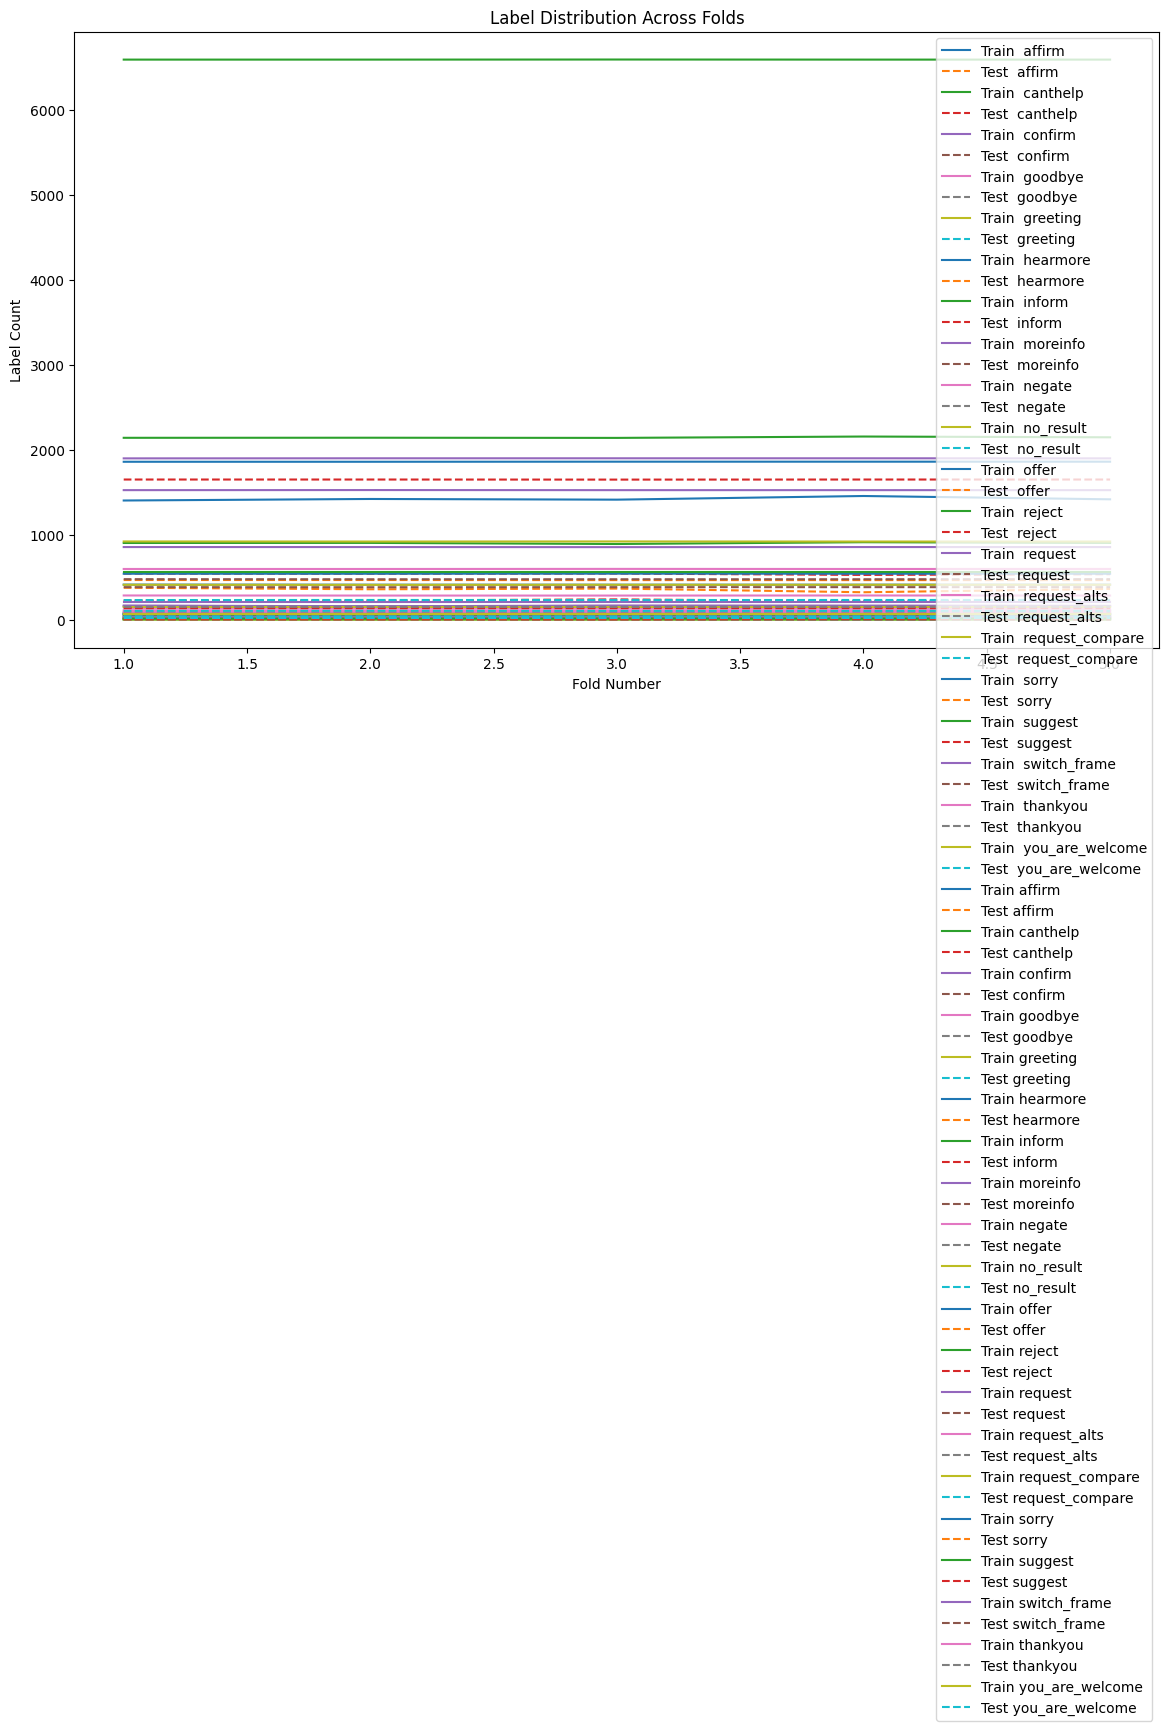

In [ ]:
def plot_label_distribution(label_counts, labels):
    train_counts = {label: [] for label in labels}
    test_counts = {label: [] for label in labels}

    for count in label_counts:
        for label in labels:
            train_counts[label].append(count['train'].get(label, 0))
            test_counts[label].append(count['test'].get(label, 0))

    fig, ax = plt.subplots(figsize=(14, 8))
    for label in labels:
        ax.plot(range(1, len(label_counts) + 1), train_counts[label], label=f'Train {label}')
        ax.plot(range(1, len(label_counts) + 1), test_counts[label], label=f'Test {label}', linestyle='--')

    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Label Count')
    ax.set_title('Label Distribution Across Folds')
    ax.legend()
    plt.show()

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Execute
k_fold_cross_validation(dataframe, k=5, epochs=3)